In [128]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


## Exploration
just to get a feel for it

Sentence embeddings:
(6, 384)


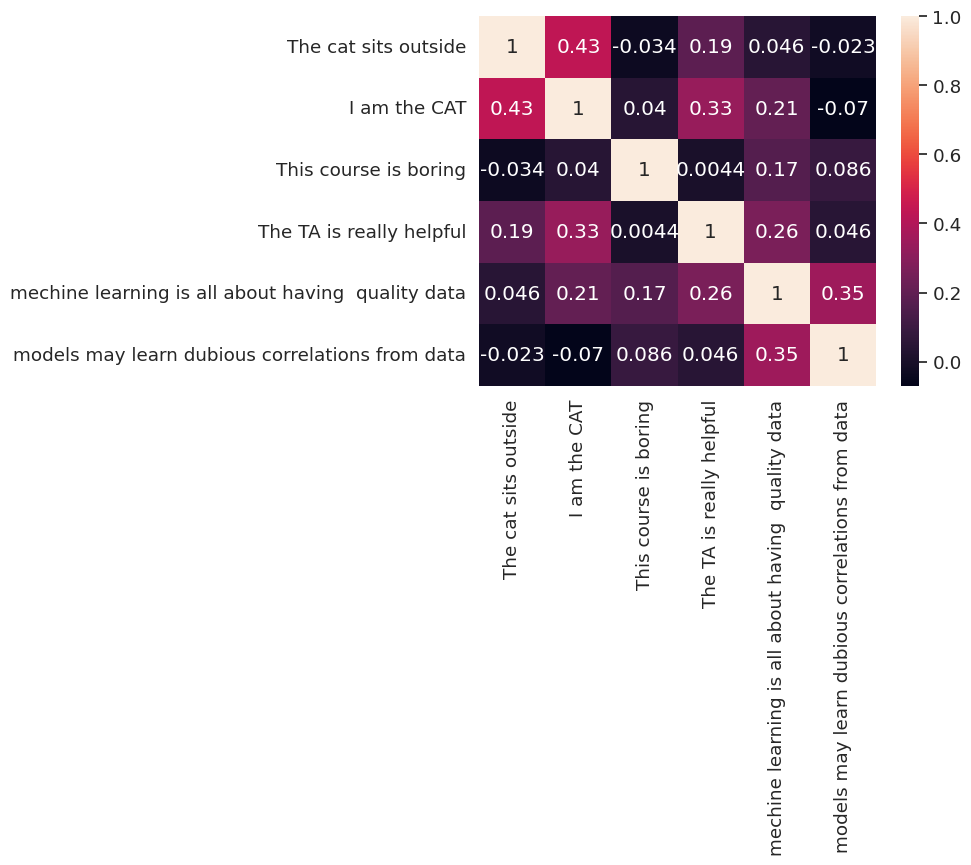

In [127]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

sentences = ["The cat sits outside",
            "I am the CAT",
            "This course is boring",
            "The TA is really helpful",
            "mechine learning is all about having  quality data",
            "models may learn dubious correlations from data",]
sentence_embeddings = model.encode(sentences)

print("Sentence embeddings:")
print(sentence_embeddings.shape)
sim_mat = util.pytorch_cos_sim(sentence_embeddings, sentence_embeddings)

#plotting the similarity matrix

sns.set(font_scale=1.2)
sns.heatmap(sim_mat, annot=True, xticklabels=sentences, yticklabels=sentences)
plt.show()



## using it on train data

### functions

In [190]:
from tqdm import tqdm
import torch
import json
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns


In [97]:

class Dataset:
    """ 
    gives preprocessed data suitable for giving to the SBERT model
    """
    def __init__(self,
                  file_path='data/train.json',
                  debug_level=0):
        
        self.df = pd.read_json(file_path)
        self.df = self.df.transpose()
        self.CTs_path = 'data/CTs/'

        self.debug_level = debug_level
    
    def __len__(self):
        return len(self.df)
    
    def extract_section(self,CTR_id, section_id):

        if type(CTR_id) != str and math.isnan(CTR_id):
            if self.debug_level > 0:
                print('CTR_id is nan')
            return []
        file_path = os.path.join(self.CTs_path, CTR_id + '.json')
        with open(file_path) as f:
            data = json.load(f)
            CTR = data[section_id]
        return CTR
    
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        section_id = sample['Section_id']
        statement = sample['Statement']
        primary_id = sample['Primary_id']
        secondary_id = sample['Secondary_id']
        primary_evidence_index = sample['Primary_evidence_index']
        secondary_evidence_index = sample['Secondary_evidence_index']

        dataset = Dataset()
        CTR_1 = dataset.extract_section(primary_id, section_id)
        CTR_2 = dataset.extract_section(secondary_id, section_id)

        primary_evidence_index_binary = [1 if i in primary_evidence_index else 0 for i in range(len(CTR_1))]
        secondary_evidence_index_binary = [1 if i in secondary_evidence_index else 0 for i in range(len(CTR_2))]
                                           
        
        return {
            "statement": statement,
            "sentences": CTR_1 + CTR_2,
            "lengths": [ len(CTR_1), len(CTR_2)],
            "labels": primary_evidence_index_binary+ secondary_evidence_index_binary,
            "_label_index": [primary_evidence_index, secondary_evidence_index]
        }
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [184]:


def calculate_similarity(dataset, model, device='cuda', club_across_samples=False):
    """
    calculates the similarity between the statement and the sentences for each sample in the dataset. 
    return:
    sims: list of list of sims 
    labels: list of list of labels 

    both are of shape (num_samples, num_sentences in ctr1 + num_sentences in ctr2 for that particular sample)
    sentences of ctr1 are first followed by sentences of ctr2 (mixed into one list).
    """
    sims = []
    labels = []

    model.to(device)
    model.eval()

    for i in tqdm(range(len(dataset))):
    # for i in range(10):
        sample = dataset[i]
        statement = sample['statement']
        sentences = sample['sentences']

        inputs = [statement] + sentences
        sample_embeddings = model.encode(inputs)
        sim = util.pytorch_cos_sim(sample_embeddings[0], sample_embeddings[1:])[0].tolist()

        sims.append(sim)
        labels.append(sample['labels'])

    if club_across_samples:
        sims = np.concatenate(sims)
        labels = np.concatenate(labels)


    return sims, labels



In [185]:

def plot_similarities(sim, labels):
    """ 
    plots the histogram of similarities for true and false samples
    """
    true_sim = []
    false_sim = []
    for i, label in enumerate(labels):

        if label:
            true_sim.append(sim[i])
        else:
            false_sim.append(sim[i])


    plt.hist(true_sim, bins=30, alpha=0.5, label='true')
    plt.hist(false_sim, bins=30, alpha=0.5, label='false')
    plt.legend(loc='upper right')
    plt.show()

In [186]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc, fpr, tpr, thresholds


### running

In [187]:
dataset = Dataset(file_path='data/dev.json')
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

sims, labels = calculate_similarity(dataset, model, device='cuda', club_across_samples=True)
# print(sims)
# print(labels)


100%|██████████| 200/200 [00:53<00:00,  3.76it/s]

[0.3325339  0.13743728 0.2184332  ... 0.30818814 0.00522391 0.24244826]
[1 1 1 ... 1 1 1]


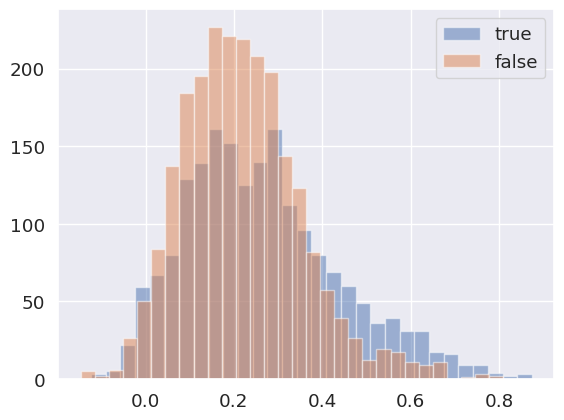

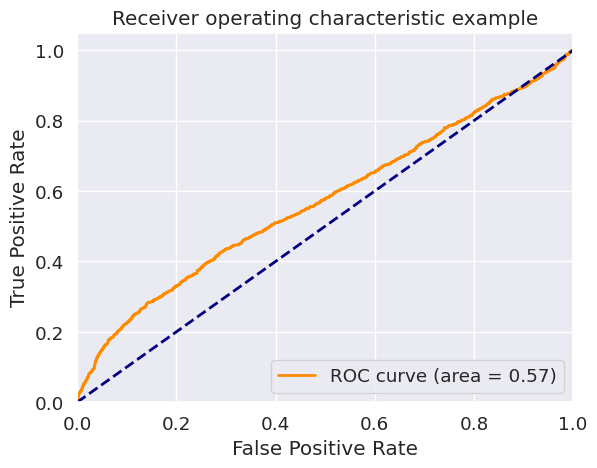

In [188]:
plot_similarities(sims, labels)
roc_auc, fpr, tpr, thresholds = plot_roc_curve(labels, sims)

In [208]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

best_threshold = thresholds[np.argmax(tpr - fpr)]
y_pred = [1 if sim > best_threshold else 0 for sim in sims]
y_true = labels

f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"""
best_threshold: {round(best_threshold, 4)} 
      
f1: {round(f1, 4)}
accuracy: {round(accuracy, 4)}
precision: {round(precision, 4)}
recall: {round(recall, 4)}""")



best_threshold: 0.3489 
      
f1: 0.3871
accuracy: 0.5982
precision: 0.6211
recall: 0.2812


Really not that helpful :(